
# Laboratorio #3 – CNN con MNIST (Pasos 2 y 3)
**Curso:** Inteligencia Artificial  
**Tema:** Convolutional Neural Networks (CNN)  
**Dataset:** MNIST (28×28, 10 clases)  




In [1]:

import os, math, random, time, itertools
from dataclasses import dataclass
from typing import Dict, Any, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt


In [ ]:

SEED = 42
BATCH_SIZE = 128
EPOCHS = 10
LR = 1e-3
DATA_DIR = "./data"      
VAL_SPLIT = 10_000       

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [ ]:

# Datos: MNIST con normalización estándar
# Promedio y desviación típica de MNIST en escala [0,1]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

try:
    full_train = datasets.MNIST(root=DATA_DIR, train=True, transform=transform, download=True)
    test_ds = datasets.MNIST(root=DATA_DIR, train=False, transform=transform, download=True)
except Exception as e:
    print(" No se pudo descargar/cargar MNIST automáticamente.")
    print("   Error:", e)
    print("   Solución: Descarga manualmente MNIST y coloca los archivos en", DATA_DIR)
    raise

train_size = len(full_train) - VAL_SPLIT
val_size = VAL_SPLIT
train_ds, val_ds = random_split(full_train, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)


(50000, 10000, 10000)

In [4]:

# Utilidades: conteo de parámetros, accuracy, bucles de train/eval, matriz de confusión

def count_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def accuracy_from_logits(logits: torch.Tensor, y: torch.Tensor) -> float:
    preds = logits.argmax(dim=1)
    correct = (preds == y).sum().item()
    return correct / y.size(0)

@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, criterion: nn.Module, device: torch.device) -> Tuple[float, float]:
    model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * y.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total_count += y.size(0)
    return total_loss / total_count, total_correct / total_count

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, running_correct, running_count = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        running_correct += (logits.argmax(1) == y).sum().item()
        running_count += y.size(0)
    return running_loss / running_count, running_correct / running_count

def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=EPOCHS):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val = -1.0
    best_state = None

    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if val_acc > best_val:
            best_val = val_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        print(f"Epoch {ep:02d}/{epochs} | Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}")
    if best_state is not None:
        model.load_state_dict(best_state)
    return history

@torch.no_grad()
def confusion_matrix(model: nn.Module, loader: DataLoader, num_classes: int = 10, device: torch.device = torch.device("cpu")) -> torch.Tensor:
    model.eval()
    cm = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = logits.argmax(1)
        for t, p in zip(y.view(-1), preds.view(-1)):
            cm[t.long(), p.long()] += 1
    return cm.cpu()


In [ ]:

# Modelos 
class MLPBaseline(nn.Module):
    def __init__(self, hidden1: int = 256, hidden2: int = 128, num_classes: int = 10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, hidden1), nn.ReLU(),
            nn.Linear(hidden1, hidden2), nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden2, num_classes),
        )
    def forward(self, x):
        return self.net(x)

class SimpleCNN(nn.Module):

    def __init__(self, c1: int = 16, c2: int = 32, fc_hidden: int = 128, num_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c1, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=c1, out_channels=c2, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(c2 * 7 * 7, fc_hidden)
        self.fc_out = nn.Linear(fc_hidden, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc_out(x)
        return x



## Paso 2 — Construcción y experimentos de la CNN



In [ ]:

criterion = nn.CrossEntropyLoss()

def make_optimizer(name: str, params, lr: float):
    name = name.lower()
    if name == "adam":
        return torch.optim.Adam(params, lr=lr)
    elif name == "sgd":
        return torch.optim.SGD(params, lr=lr, momentum=0.9)
    else:
        raise ValueError(f"Optimizador no reconocido: {name}")

# Lista de configuraciones de CNN a probar
cnn_experiments = [
    {"model": "cnn", "c1": 16, "c2": 32, "fc_hidden": 128, "opt": "adam", "lr": 1e-3},
    {"model": "cnn", "c1": 32, "c2": 64, "fc_hidden": 256, "opt": "sgd",  "lr": 0.01},
    {"model": "cnn", "c1": 8,  "c2": 16, "fc_hidden": 64,  "opt": "adam", "lr": 1e-3},
]

results: List[Dict[str, Any]] = []

for cfg in cnn_experiments:
    print("\nExperimento CNN:", cfg, )
    model = SimpleCNN(c1=cfg["c1"], c2=cfg["c2"], fc_hidden=cfg["fc_hidden"]).to(device)
    opt = make_optimizer(cfg["opt"], model.parameters(), lr=cfg["lr"])

    hist = train_model(model, train_loader, val_loader, opt, criterion, device, epochs=EPOCHS)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    params = count_params(model)

    results.append({
        "name": f"CNN(c1={cfg['c1']},c2={cfg['c2']},fc={cfg['fc_hidden']},{cfg['opt']})",
        "type": "CNN",
        "val_acc": val_acc,
        "test_acc": test_acc,
        "params": params,
        "model_obj": model,  
    })

results_sorted = sorted(results, key=lambda d: d["val_acc"], reverse=True)
for r in results_sorted:
    print(f"{r['name']}: val_acc={r['val_acc']:.4f}, test_acc={r['test_acc']:.4f}, params={r['params']}")



Experimento CNN: {'model': 'cnn', 'c1': 16, 'c2': 32, 'fc_hidden': 128, 'opt': 'adam', 'lr': 0.001}


/Users/alexismesias/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01/10 | Train Loss 0.2592 Acc 0.9245 | Val Loss 0.0926 Acc 0.9742
Epoch 02/10 | Train Loss 0.0663 Acc 0.9798 | Val Loss 0.0580 Acc 0.9832
Epoch 03/10 | Train Loss 0.0483 Acc 0.9850 | Val Loss 0.0504 Acc 0.9860
Epoch 04/10 | Train Loss 0.0342 Acc 0.9894 | Val Loss 0.0534 Acc 0.9841
Epoch 05/10 | Train Loss 0.0279 Acc 0.9912 | Val Loss 0.0523 Acc 0.9847
Epoch 06/10 | Train Loss 0.0240 Acc 0.9923 | Val Loss 0.0449 Acc 0.9865
Epoch 07/10 | Train Loss 0.0168 Acc 0.9946 | Val Loss 0.0412 Acc 0.9884
Epoch 08/10 | Train Loss 0.0138 Acc 0.9954 | Val Loss 0.0464 Acc 0.9875
Epoch 09/10 | Train Loss 0.0126 Acc 0.9957 | Val Loss 0.0457 Acc 0.9880
Epoch 10/10 | Train Loss 0.0094 Acc 0.9971 | Val Loss 0.0447 Acc 0.9882

Experimento CNN: {'model': 'cnn', 'c1': 32, 'c2': 64, 'fc_hidden': 256, 'opt': 'sgd', 'lr': 0.01}
Epoch 01/10 | Train Loss 0.3269 Acc 0.9037 | Val Loss 0.1116 Acc 0.9636
Epoch 02/10 | Train Loss 0.0689 Acc 0.9790 | Val Loss 0.0621 Acc 0.9815
Epoch 03/10 | Train Loss 0.0482 Acc 0


### Línea base (laboratorio anterior)



In [7]:

class MLP(nn.Module):
    def __init__(self, layer_sizes, activation_fn):
        super().__init__()
        layers = []
        for in_dim, out_dim in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            if out_dim != layer_sizes[-1]:
                layers.append(activation_fn())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  
        return self.net(x)


BaselineAnterior = MLP


In [8]:

baseline_cfg = {"hidden1": 256, "hidden2": 128, "opt": "adam", "lr": 1e-3}

print("\nEntrenando modelo anterior")

use_user_baseline = False
baseline = None

try:
    BaselineAnterior  
    try:
        baseline = BaselineAnterior().to(device)
        use_user_baseline = True
        print("Usando BaseLine anterior")
    except TypeError as e:
        print("La clase BaselineAnterior requiere argumentos:", e)
        print(" Ajustar la instanciación aquí para pasar los parámetros adecuados.")
except NameError:
    pass

if baseline is None:
    print("Usando fallback MLPBaseline()")
    baseline = MLPBaseline(hidden1=baseline_cfg["hidden1"], hidden2=baseline_cfg["hidden2"]).to(device)

opt_base = torch.optim.Adam(baseline.parameters(), lr=baseline_cfg["lr"])

_ = train_model(baseline, train_loader, val_loader, opt_base, criterion, device, epochs=EPOCHS)
val_loss_b, val_acc_b = evaluate(baseline, val_loader, criterion, device)
test_loss_b, test_acc_b = evaluate(baseline, test_loader, criterion, device)
params_b = count_params(baseline)

baseline_result = {
    "name": ("TuBaseline(BaselineAnterior)" if use_user_baseline else f"MLP(h1={baseline_cfg['hidden1']},h2={baseline_cfg['hidden2']})"),
    "type": "BASELINE",
    "val_acc": val_acc_b,
    "test_acc": test_acc_b,
    "params": params_b,
    "model_obj": baseline,
}

print(f"Baseline -> val_acc={val_acc_b:.4f}, test_acc={test_acc_b:.4f}, params={params_b}")



Entrenando modelo anterior
La clase BaselineAnterior requiere argumentos: __init__() missing 2 required positional arguments: 'layer_sizes' and 'activation_fn'
 Ajustar la instanciación aquí para pasar los parámetros adecuados.
Usando fallback MLPBaseline()
Epoch 01/10 | Train Loss 0.3193 Acc 0.9058 | Val Loss 0.1573 Acc 0.9517
Epoch 02/10 | Train Loss 0.1247 Acc 0.9622 | Val Loss 0.1211 Acc 0.9627
Epoch 03/10 | Train Loss 0.0846 Acc 0.9735 | Val Loss 0.1052 Acc 0.9693
Epoch 04/10 | Train Loss 0.0626 Acc 0.9798 | Val Loss 0.0910 Acc 0.9721
Epoch 05/10 | Train Loss 0.0500 Acc 0.9836 | Val Loss 0.0935 Acc 0.9728
Epoch 06/10 | Train Loss 0.0385 Acc 0.9878 | Val Loss 0.0899 Acc 0.9751
Epoch 07/10 | Train Loss 0.0361 Acc 0.9881 | Val Loss 0.0945 Acc 0.9727
Epoch 08/10 | Train Loss 0.0277 Acc 0.9907 | Val Loss 0.0857 Acc 0.9762
Epoch 09/10 | Train Loss 0.0243 Acc 0.9921 | Val Loss 0.1082 Acc 0.9737
Epoch 10/10 | Train Loss 0.0214 Acc 0.9925 | Val Loss 0.0976 Acc 0.9761
Baseline -> val_acc=0

In [ ]:

# Resumen tabular de resultados
import pandas as pd

all_results = results_sorted + [baseline_result]
df = pd.DataFrame([
    {"Modelo": r["name"], "Tipo": r["type"], "Val_Acc": r["val_acc"], "Test_Acc": r["test_acc"], "Parámetros": r["params"],
     "Acc_por_MillónParams": (r["test_acc"] / (r["params"]/1_000_000)) if r["params"]>0 else float("nan")}
    for r in all_results
])

# Orden por Test_Acc descendente
df = df.sort_values(by="Test_Acc", ascending=False).reset_index(drop=True)
df


,Modelo,Tipo,Val_Acc,Test_Acc,Parámetros,Acc_por_MillónParams
0,"CNN(c1=16,c2=32,fc=128,adam)",CNN,0.9884,0.9903,206922,4.785861
1,"CNN(c1=32,c2=64,fc=256,sgd)",CNN,0.9896,0.9900,824458,1.200789
2,"CNN(c1=8,c2=16,fc=64,adam)",CNN,0.9877,0.9879,52138,18.947792
3,"MLP(h1=256,h2=128)",BASELINE,0.9762,0.9780,235146,4.159118



## Paso 3 — Benchmark: CNN vs Línea base



/Users/alexismesias/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


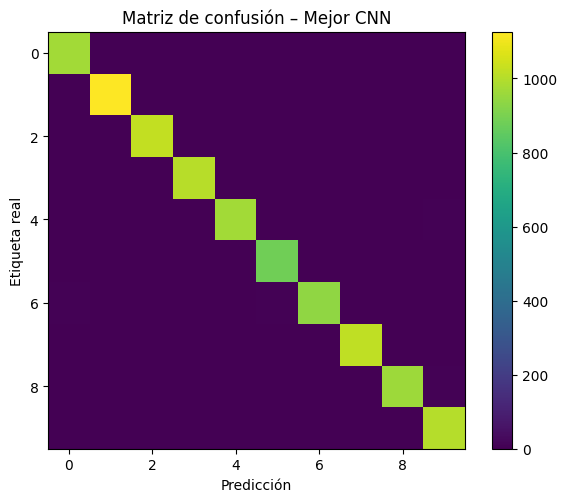

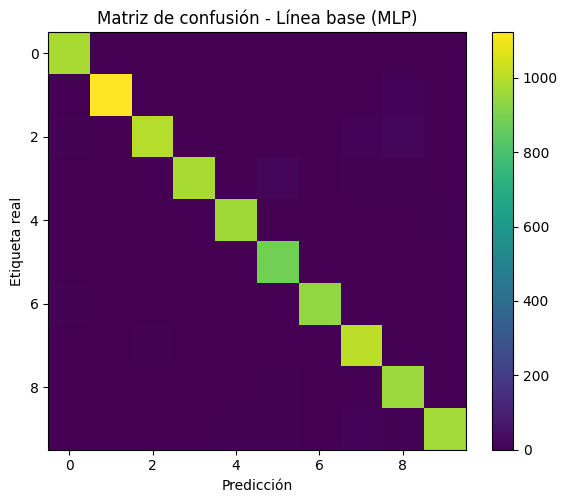


Resumen benchmark 
Mejor CNN: CNN(c1=32,c2=64,fc=256,sgd) | Val_Acc=98.96% | Test_Acc=99.00% | Params=824,458
Baseline:  MLP(h1=256,h2=128) | Val_Acc=97.62% | Test_Acc=97.80% | Params=235,146
Eficiencia (Acc por millón de parámetros) -> CNN: 1.2008  vs  Baseline: 4.1591


In [ ]:

# Mejor CNN según validación
best_cnn = next((r for r in results_sorted if r["type"] == "CNN"), None)
assert best_cnn is not None, "No hay resultados de CNN."

#  Matriz de confusión para la mejor CNN 
cm_cnn = confusion_matrix(best_cnn["model_obj"], test_loader, num_classes=10, device=device)
plt.figure(figsize=(6,5))
plt.imshow(cm_cnn.numpy(), interpolation="nearest")
plt.title("Matriz de confusión – Mejor CNN")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.colorbar()
plt.tight_layout()
plt.show()

# Matriz de confusión para la línea base 
cm_base = confusion_matrix(baseline_result["model_obj"], test_loader, num_classes=10, device=device)
plt.figure(figsize=(6,5))
plt.imshow(cm_base.numpy(), interpolation="nearest")
plt.title("Matriz de confusión - Línea base (MLP)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.colorbar()
plt.tight_layout()
plt.show()

def pretty_pct(x: float) -> str:
    return f"{100.0*x:.2f}%"

print("\nResumen benchmark ")
print(f"Mejor CNN: {best_cnn['name']} | Val_Acc={pretty_pct(best_cnn['val_acc'])} | Test_Acc={pretty_pct(best_cnn['test_acc'])} | Params={best_cnn['params']:,}")
print(f"Baseline:  {baseline_result['name']} | Val_Acc={pretty_pct(baseline_result['val_acc'])} | Test_Acc={pretty_pct(baseline_result['test_acc'])} | Params={baseline_result['params']:,}")

eff_cnn  = best_cnn["test_acc"] / (best_cnn["params"] / 1_000_000)
eff_base = baseline_result["test_acc"] / (baseline_result["params"] / 1_000_000)
print(f"Eficiencia (Acc por millón de parámetros) -> CNN: {eff_cnn:.4f}  vs  Baseline: {eff_base:.4f}")


